In [1]:
import pandas as pd
import json
from torch import cuda
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, DebertaTokenizerFast
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset, concatenate_datasets, DatasetDict
import ast
from transformers import Trainer, EarlyStoppingCallback
from transformers import TrainingArguments
from docx import Document
from docx.shared import RGBColor
from transformers import DataCollatorForTokenClassification
from sklearn.model_selection import KFold
import pickle
from src.models.helpers import *

/home/ozan/anaconda3/envs/lara-medh/lib/python3.12/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [29]:
def train_model(model_config):
    for fold_no in model_config['fold_range']:  
        # Load the tokenizer
        # tokenizer = AutoTokenizer.from_pretrained(model_config['checkpoint_path'])  
        if 'deberta' in  model_config['checkpoint_path']:
            tokenizer = DebertaTokenizerFast.from_pretrained(model_config['checkpoint_path'], add_prefix_space=True)
        else:
            tokenizer = AutoTokenizer.from_pretrained(model_config['checkpoint_path'])

        data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

        # Load the model
        # model = AutoModelForTokenClassification.from_pretrained(model_config['checkpoint_path'])
        model = AutoModelForTokenClassification.from_pretrained(
        model_config['checkpoint_path'],
        # 'samrawal/bert-base-uncased_clinical-ner',
        # 'microsoft/deberta-base',
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True
        )

        # Load the evaluation data

        # eval_dataset = load_dataset('csv', data_files=f'data/processed/{eval_dataset_name}/final_eval.csv')
        # eval_dataset = eval_dataset.map(transform)
        if fold_no < 5:
            train_dataset = load_dataset('csv', data_files=f'data/processed/{model_config['train_dataset_name']}/train_fold_{fold_no}.csv')
            eval_dataset = load_dataset('csv', data_files=f'data/processed/{model_config['eval_dataset_name']}/test_fold_{fold_no}.csv')
        else:
            train_dataset = load_dataset('csv', data_files=f'data/processed/{model_config['train_dataset_name']}/test_fold_{fold_no-5}.csv')
            eval_dataset = load_dataset('csv', data_files=f'data/processed/{model_config['eval_dataset_name']}/train_fold_{fold_no-5}.csv')
    
    
        # combined = concatenate_datasets([d1['train'], d2['train']])
        # eval_dataset = DatasetDict({'train': combined})
        train_dataset = train_dataset.map(transform)
        eval_dataset = eval_dataset.map(transform)
        
        
        print(eval_dataset)
        
        # word ids of the tokenized mtsamples to find the original words
        eval_sentences = eval_dataset['train']['sentence']
        eval_word_ids = []
        for sentence in eval_sentences:
            eval_word_ids.append(tokenizer(sentence, truncation=True, is_split_into_words=True).word_ids())
        
        train_sentences = train_dataset['train']['sentence']
        train_word_ids = []
        for sentence in train_sentences:
            train_word_ids.append(tokenizer(sentence, truncation=True, is_split_into_words=True).word_ids())

  

        # Prepare the evaluation dataset
        eval_dataset = eval_dataset.map(lambda examples: tokenize_and_align_labels_wrapper(examples, tokenizer), batched=True, remove_columns=eval_dataset['train'].column_names)
        train_dataset = train_dataset.map(lambda examples: tokenize_and_align_labels_wrapper(examples, tokenizer), batched=True, remove_columns=train_dataset['train'].column_names)

        # split_dataset = eval_dataset['train'].train_test_split(test_size=0.5)


        # Define the training arguments
        training_args = TrainingArguments(
            output_dir=model_config['output_model_dir'], # path of aft-ft
            overwrite_output_dir=True,
            per_device_train_batch_size= model_config['batch_size'],
            per_device_eval_batch_size= model_config['batch_size'],
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            learning_rate=model_config['learning_rate'],
            num_train_epochs=model_config['epochs'],
            logging_strategy="epoch",
        )

        # Initialize the Trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset['train'],
            eval_dataset=eval_dataset['train'],
            data_collator=data_collator,
            compute_metrics=TrainingMonitor().compute_metrics_factory(eval_word_ids, fold_no, eval_dataset_name=model_config['eval_dataset_name'], model_name=model_config['model_name']),
            callbacks=[EarlyStoppingCallback(early_stopping_patience=5, early_stopping_threshold=0.005)]
        )
        
        # print("Save tokenizer to:", model_config['output_model_dir'])
        # tokenizer.save_pretrained(model_config['output_model_dir'])

        trainer.train()

        # print("Save model to:", model_config['output_model_dir'])
        # model.save_pretrained(model_config['output_model_dir'])
        
        # Evaluate model
        trainer.evaluate(eval_dataset['train'])
     
    

In [38]:
# eval_dataset_name = 'mtsamples2'
model_names = ['deberta-ft-aft-ft'] #['biobert-mt', 'scibert-mt', 'bluebert-mt', 'bert-mt', 'bertclinical-mt', 'bioclinicalbert-mt', 'deberta-mt']
model_checkpoints = ['models/models_deberta-ft_fold0-2024-06-15_19-38-53'] #['monologg/biobert_v1.1_pubmed'] #['allenai/scibert_scivocab_uncased', 'bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16', 'google-bert/bert-base-uncased', 'samrawal/bert-base-uncased_clinical-ner' ,'emilyalsentzer/Bio_ClinicalBERT', 'microsoft/deberta-base']
for model_name, model_checkpoint in zip(model_names, model_checkpoints):

    model_config = dict(
        train_dataset_name='cross-validation',
        eval_dataset_name = 'cross-validation',
        checkpoint_path = model_checkpoint, #"models/models_deberta-finetuned-ner_fold0_checkpoint-4710-2024-04-29_22-20-58", #'models/deberta-finetuned-ner/fold0/checkpoint-4710', #f'models/models_bert-ft-ft-2024-04-22_20-49-48', # "models/bert-finetuned-ner/fold0/checkpoint-2826", # f'models/models_bert-finetuned-ner_fold0_checkpoint-4710-2024-04-11_11-37-04',
        epochs = 50,
        batch_size = 4,
        learning_rate = 1e-5,
        fold_range = range(5, 10),
        model_name = model_name,
        output_model_dir = f'models/{model_name}' 
        )
        
    train_model(model_config)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of DebertaForTokenClassification were not initialized from the model checkpoint at models/models_deberta-ft_fold0-2024-06-15_19-38-53 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DatasetDict({
    train: Dataset({
        features: ['sentence', 'tag'],
        num_rows: 98
    })
})


Map:   0%|          | 0/98 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.021900,0.668551,0.653081,0.453030,0.439612,0.779158
2,0.462800,0.513307,0.785237,0.699753,0.724942,0.847695
3,0.315000,0.475822,0.791111,0.796024,0.787764,0.867735
4,0.228600,0.501002,0.790215,0.781557,0.783014,0.862124
5,0.165400,0.522789,0.800140,0.786378,0.783638,0.865331
6,0.128300,0.574458,0.800657,0.767751,0.775900,0.863727
7,0.094700,0.573541,0.803063,0.793258,0.788927,0.872946
8,0.055500,0.650165,0.811015,0.781193,0.786466,0.872545


/home/ozan/anaconda3/envs/lara-medh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ozan/anaconda3/envs/lara-medh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ozan/anaconda3/envs/lara-medh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of DebertaForTokenClassification were not initialized from the model checkpoint at models/models_deberta-ft_fold0-2024-06-15_19-38-53 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DatasetDict({
    train: Dataset({
        features: ['sentence', 'tag'],
        num_rows: 98
    })
})


Map:   0%|          | 0/98 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.065900,0.637648,0.509002,0.474688,0.475112,0.811808
2,0.546300,0.510361,0.738271,0.660886,0.687725,0.850759
3,0.352400,0.476539,0.734197,0.780452,0.754840,0.861419
4,0.245600,0.484643,0.739938,0.808660,0.768412,0.864699
5,0.186000,0.475350,0.776238,0.810206,0.788953,0.876179
6,0.128600,0.507870,0.761798,0.819230,0.784253,0.875359
7,0.100500,0.589126,0.746724,0.830212,0.779637,0.869619
8,0.071100,0.599184,0.754018,0.842164,0.787786,0.874539
9,0.077500,0.618495,0.757916,0.811972,0.778706,0.872899
10,0.042900,0.703558,0.760691,0.810662,0.776970,0.871669


/home/ozan/anaconda3/envs/lara-medh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ozan/anaconda3/envs/lara-medh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ozan/anaconda3/envs/lara-medh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of DebertaForTokenClassification were not initialized from the model checkpoint at models/models_deberta-ft_fold0-2024-06-15_19-38-53 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DatasetDict({
    train: Dataset({
        features: ['sentence', 'tag'],
        num_rows: 98
    })
})


Map:   0%|          | 0/98 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.126000,0.645864,0.526669,0.452780,0.471884,0.802164
2,0.554300,0.521068,0.631878,0.573295,0.587682,0.831530
3,0.417700,0.484378,0.799872,0.682771,0.723259,0.850464
4,0.275100,0.470394,0.796639,0.755161,0.774179,0.865147
5,0.174800,0.492158,0.809359,0.776183,0.790320,0.867465
6,0.144800,0.507529,0.791086,0.771950,0.779192,0.867079
7,0.114900,0.549119,0.781748,0.770802,0.774625,0.864760
8,0.074300,0.602725,0.787101,0.783369,0.780567,0.867079
9,0.050200,0.644295,0.808243,0.758772,0.778160,0.869784
10,0.037100,0.668211,0.795076,0.788239,0.788516,0.869397


/home/ozan/anaconda3/envs/lara-medh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ozan/anaconda3/envs/lara-medh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ozan/anaconda3/envs/lara-medh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of DebertaForTokenClassification were not initialized from the model checkpoint at models/models_deberta-ft_fold0-2024-06-15_19-38-53 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DatasetDict({
    train: Dataset({
        features: ['sentence', 'tag'],
        num_rows: 98
    })
})


Map:   0%|          | 0/98 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.083000,0.712993,0.495756,0.469220,0.465074,0.786893
2,0.529800,0.565361,0.672878,0.527710,0.522018,0.819884
3,0.373900,0.475285,0.824747,0.666277,0.709533,0.848863
4,0.278700,0.492280,0.843830,0.720417,0.761463,0.859117
5,0.199400,0.475437,0.841813,0.773431,0.803883,0.870263
6,0.168400,0.532548,0.830252,0.771489,0.793372,0.869371
7,0.127700,0.531660,0.842473,0.770087,0.802510,0.875167
8,0.102500,0.602789,0.820838,0.784671,0.798704,0.865805
9,0.097900,0.593087,0.825124,0.788097,0.805212,0.873830
10,0.071000,0.643664,0.823367,0.790293,0.804285,0.870263


/home/ozan/anaconda3/envs/lara-medh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ozan/anaconda3/envs/lara-medh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ozan/anaconda3/envs/lara-medh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of DebertaForTokenClassification were not initialized from the model checkpoint at models/models_deberta-ft_fold0-2024-06-15_19-38-53 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DatasetDict({
    train: Dataset({
        features: ['sentence', 'tag'],
        num_rows: 98
    })
})


Map:   0%|          | 0/98 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.102900,0.638470,0.483158,0.535899,0.507004,0.815081
2,0.575000,0.540618,0.606929,0.581383,0.564875,0.833932
3,0.393600,0.472247,0.777732,0.728486,0.730364,0.858618
4,0.297200,0.454442,0.817674,0.763456,0.779099,0.873878
5,0.216200,0.469670,0.810200,0.759713,0.777808,0.868492
6,0.148000,0.498814,0.837533,0.727632,0.764981,0.873429
7,0.119800,0.554434,0.835743,0.730005,0.768846,0.868941
8,0.109400,0.523291,0.791129,0.774618,0.780376,0.876122
9,0.075100,0.563189,0.803181,0.769445,0.781387,0.877917


/home/ozan/anaconda3/envs/lara-medh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ozan/anaconda3/envs/lara-medh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ozan/anaconda3/envs/lara-medh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

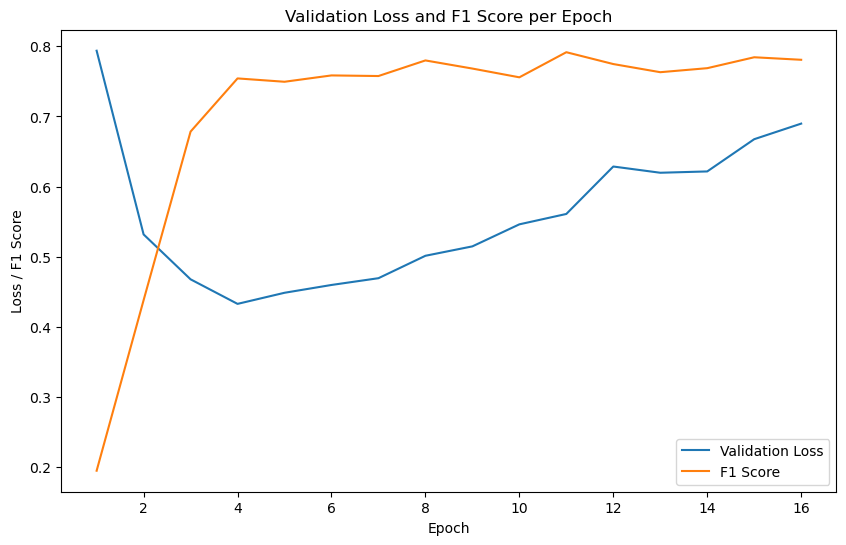

In [78]:
import matplotlib.pyplot as plt

# Data
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
validation_loss = [0.793684, 0.531887, 0.467905, 0.432901, 0.448712, 0.459855, 0.469496, 0.501452, 0.514860, 0.546255, 0.561048, 0.628652, 0.619776, 0.621651, 0.667586, 0.689805]
f1_score = [0.195125, 0.438177, 0.678420, 0.754222, 0.749447, 0.758489, 0.757612, 0.779846, 0.768259, 0.755781, 0.791562, 0.774690, 0.763073, 0.768807, 0.784362, 0.780769]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.plot(epochs, f1_score, label='F1 Score')

plt.title('Validation Loss and F1 Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss / F1 Score')
plt.legend()

plt.show()

# Model Comparison: 5x2cv

In [134]:
# # generate 5 different train-test data. Shuffle and split 5 times.
# import pandas as pd
# from sklearn.model_selection import ShuffleSplit

# # Let's assume you have a pandas DataFrame called 'df' with your dataset.
# data1 = pd.read_csv('data/processed/mtsamples2/mtsamples_extra.csv')
# data2 = pd.read_csv("data/processed/mtsamples2/final_eval.csv")
# df = pd.concat([data1, data2])


# # Define the ShuffleSplit object to split the data into 2 parts, for 5 splits
# ss = ShuffleSplit(n_splits=5, test_size=0.5, random_state=0)

# # This will shuffle and split the data 5 times
# for fold, (train_index, test_index) in enumerate(ss.split(df)):
#     # Split the data
#     train_set = df.iloc[train_index]
#     test_set = df.iloc[test_index]
    
#     # Save each fold to CSV
#     train_set.to_csv(f'data/processed/cross-validation/train_fold_{fold}.csv', index=False)
#     test_set.to_csv(f'data/processed/cross-validation/test_fold_{fold}.csv', index=False)

In [23]:
# save scores
import json
import os
import numpy as np
import pandas as pd
# This is the base directory where your fold reports are located.
dataset_name = 'cross-validation'
base_dir = f'analysis/{dataset_name}/reports'  
# Initialize dictionaries to hold all the metric values from each fold.
binary_metrics = {
    'O': {'precision': [], 'recall': [], 'f1-score': []},
    'I': {'precision': [], 'recall': [], 'f1-score': []},
    'macro avg': {'precision': [], 'recall': [], 'f1-score': []},
    'weighted avg': {'precision': [], 'recall': [], 'f1-score': []}
}

multiclass_metrics = {
    "macro avg": {'precision': [], 'recall': [], 'f1-score': []},
    "weighted avg": {'precision': [], 'recall': [], 'f1-score': []},
    "macro_wo_O": {'precision': [], 'recall': [], 'f1-score': []}

}

# Process each fold
for fold in range(10):
    fold_dir = os.path.join(base_dir, f'fold{fold}')

    # Load binary classification report
    with open(os.path.join(fold_dir, 'binary_classification_report.json'), 'r') as f:
        binary_report = json.load(f)
        for category in binary_metrics.keys():
            for metric in binary_metrics[category].keys():
                binary_metrics[category][metric].append(binary_report[category][metric])

    # Load multiclass classification report
    multi_df = pd.read_json(os.path.join(fold_dir, 'multiclass_classification_report.json'))
  
    # with open(os.path.join(fold_dir, 'multiclass_classification_report.json'), 'r') as f:
    multiclass_report = multi_df.T.to_dict()
    # print(multiclass_report)

    for category in multiclass_metrics.keys():

        for metric in multiclass_metrics[category].keys():
            multiclass_metrics[category][metric].append(multiclass_report[category][metric])

print(multiclass_metrics['macro_wo_O']['f1-score'])
print(binary_metrics['macro avg']['f1-score'])

# rearrange array
def rearrange_array(array):
    return [x for pair in zip(array[:5], array[5:]) for x in pair]

import pickle
with open('analysis/statistical_test/bc_multiclass_scores.pkl', 'wb') as f:
   pickle.dump(rearrange_array(multiclass_metrics['macro_wo_O']['f1-score']), f)

with open('analysis/statistical_test/bc_binary_scores.pkl', 'wb') as f:
   pickle.dump(rearrange_array(binary_metrics['macro avg']['f1-score']), f)




[0.762, 0.745, 0.8, 0.735, 0.772, 0.718, 0.761, 0.763, 0.744, 0.747]
[0.9278379730960091, 0.9198306621921345, 0.9217432140509063, 0.9117478312695445, 0.9110813980958032, 0.8999021780854146, 0.9033000527240529, 0.911642198702629, 0.9167177455728741, 0.9156476328682501]


In [24]:
from scipy import stats
def combined_ftest_5x2cv(scores1, scores2):
    """Perform the Combined 5x2CV F-test on two sets of
    model scores to compare their performance.

    Assume R1CV1, R1CV2, R2CV1 ... order
    where R1CV1 is cross-validation repeat 1 and split 1
    Args:
        scores1 (list): Regressor 1 scores on the splits
        scores2 (list): Regressor 2 scores on the splits
    Returns:
        f_stat (float): The F-statistic
        pvalue (float):  If the chosen significance level is larger than
        the p-value, we reject the null hypothesis and accept that
        there are significant differences in the two compared models.
    """
    variances = []
    differences = []
    for i in range(5):
        scores_diff1 = scores1[i * 2] - scores2[i * 2]
        scores_diff2 = scores1[i * 2 + 1] - scores2[i * 2 + 1]
        score_mean = (scores_diff1 + scores_diff2) / 2.0
        score_var = (scores_diff1 - score_mean) ** 2 + \
            (scores_diff2 - score_mean) ** 2

        differences.extend([scores_diff1**2, scores_diff2**2])
        variances.append(score_var)

    numerator = sum(differences)
    denominator = 2 * (sum(variances))
    f_stat = numerator / denominator

    pvalue = stats.f.sf(f_stat, 10, 5)
    return float(f_stat), float(pvalue)

In [25]:
scores1 = pd.read_pickle('analysis/statistical_test/bc_multiclass_scores.pkl')
scores2 = pd.read_pickle('analysis/statistical_test/bc_binary_scores.pkl')

# f_stat, p_val = combined_ftest_5x2cv(scores1, scores2)
# print(f_stat)
# print(p_val)

print("multi:", np.mean(scores1), np.std(scores1))
print("binary:", np.mean(scores2), np.std(scores2))
scores1= [0.781, 0.766, 0.8130000000000001, 0.751, 0.782, 0.742, 0.791, 0.79, 0.754, 0.798]
scores2 = [0.797, 0.767, 0.8260000000000001, 0.751, 0.798, 0.771, 0.773, 0.782, 0.773, 0.778]

# # [0.9209982970585537, 0.922257053291536, 0.9292719504258511, 0.9098580736089483, 0.9181765860647222, 0.9016029038038252, 0.906292184767725, 0.9083861375623916, 0.9101304607361893, 0.9243926080724805]
# # Performing the paired t-test
t_statistic, p_value = stats.ttest_rel(scores1, scores2)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

multi: 0.7547 0.02125111761766898
binary: 0.9139450886657619 0.007924022651601064
T-statistic: -0.9215634330884481
P-value: 0.38079647345525747
